# Machine Learning with PyTorch and Scikit-Learn  
# -- Code Examples

## Package version checks

Add folder to path in order to load from the check_packages.py script:

In [5]:
import sys
sys.path.insert(0, '..')

Check recommended package versions:

<br>
<br>

In [6]:
from IPython.display import Image
%matplotlib inline

# Modeling complex functions with artificial neural networks

...

## Obtaining and preparing the MNIST dataset

The MNIST dataset is publicly available at http://yann.lecun.com/exdb/mnist/ and consists of the following four parts:

- Training set images: train-images-idx3-ubyte.gz (9.9 MB, 47 MB unzipped, 60,000 examples)
- Training set labels: train-labels-idx1-ubyte.gz (29 KB, 60 KB unzipped, 60,000 labels)
- Test set images: t10k-images-idx3-ubyte.gz (1.6 MB, 7.8 MB, 10,000 examples)
- Test set labels: t10k-labels-idx1-ubyte.gz (5 KB, 10 KB unzipped, 10,000 labels)



In [7]:
import tensorflow
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Flatten the images to match the 784 feature format
X = X_train.reshape(-1, 28*28)
y = y_train

print(X.shape)
print(y.shape)


(60000, 784)
(60000,)


Normalize to [-1, 1] range:

In [8]:
X = ((X / 255.) - .5) * 2

Visualize the first digit of each class:

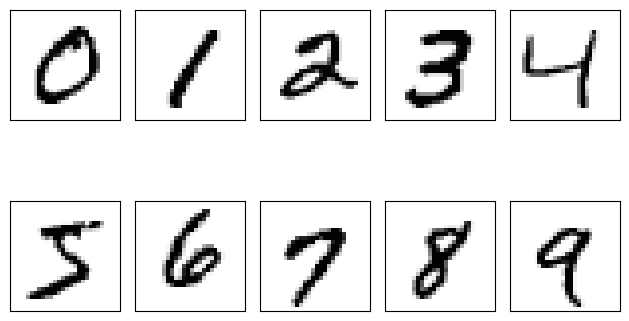

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_4.png', dpi=300)
plt.show()

Visualize 25 different versions of "7":

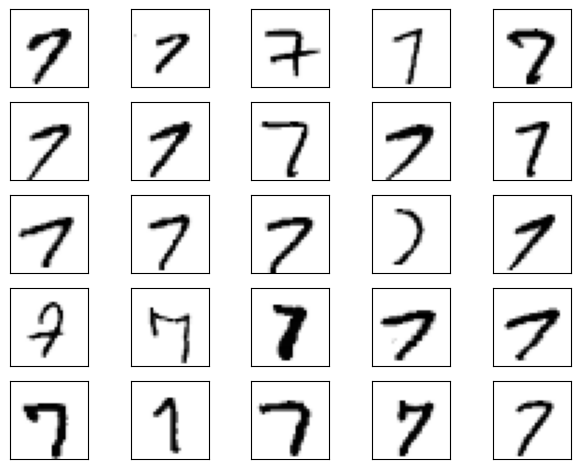

In [10]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('figures/11_5.png', dpi=300)
plt.show()

Split into training, validation, and test set:

In [11]:
from sklearn.model_selection import train_test_split

# Split into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123, stratify=y)

# Optional: Further split the training data into training and validation sets (e.g., 10% validation)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.1, random_state=123, stratify=y_train)

# Optional to free up some memory by deleting non-used arrays:
del X, y

<br>
<br>

## Implementing a multi-layer perceptron

In [12]:
import numpy as np

In [13]:
##########################
### MODEL
##########################

def sigmoid(z):
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class NeuralNetMLP2:

    def __init__(self, num_features, num_hidden1, num_hidden2, num_classes, random_seed=123):
        super().__init__()

        self.num_classes = num_classes

        # hidden
        rng = np.random.RandomState(random_seed)

        # First hidden layer
        self.weight_h1 = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden1, num_features))
        self.bias_h1 = np.zeros(num_hidden1)

        # Second hidden layer
        self.weight_h2 = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden2, num_hidden1))
        self.bias_h2 = np.zeros(num_hidden2)

        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden2))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        # First Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden1, n_features].T
        # output dim: [n_examples, n_hidden1]
        z_h1 = np.dot(x, self.weight_h1.T) + self.bias_h1
        a_h1 = sigmoid(z_h1)

        # Second Hidden layer
        # input dim: [n_examples, n_hidden1] dot [n_hidden2, n_hidden1].T
        # output dim: [n_examples, n_hidden2]
        z_h2 = np.dot(a_h1, self.weight_h2.T) + self.bias_h2
        a_h2 = sigmoid(z_h2)

        # Output layer
        # input dim: [n_examples, n_hidden2] dot [n_classes, n_hidden2].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h2, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h1, a_h2, a_out

    def backward(self, x, a_h1, a_h2, a_out, y):

        #########################
        ### Output layer weights
        #########################

        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use

        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights

        # [n_examples, n_hidden2]
        d_z_out__dw_out = a_h2

        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden2]
        # output dim: [n_classes, n_hidden2]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)


        #################################
        # Part 2: dLoss/dHidden2Weights
        ## = DeltaOut * dOutNet/dHidden2Act * dHidden2Act/dHidden2Net * dHidden2Net/dWeight

        # [n_classes, n_hidden2]
        d_z_out__a_h2 = self.weight_out

        # output dim: [n_examples, n_hidden2]
        d_loss__a_h2 = np.dot(delta_out, d_z_out__a_h2)

        # [n_examples, n_hidden2]
        d_a_h2__d_z_h2 = a_h2 * (1. - a_h2) # sigmoid derivative

        # [n_examples, n_hidden1]
        d_z_h2__d_w_h2 = a_h1

        # output dim: [n_hidden2, n_hidden1]
        d_loss__d_w_h2 = np.dot((d_loss__a_h2 * d_a_h2__d_z_h2).T, d_z_h2__d_w_h2)
        d_loss__d_b_h2 = np.sum((d_loss__a_h2 * d_a_h2__d_z_h2), axis=0)


        #################################
        # Part 3: dLoss/dHidden1Weights
        ## = DeltaHidden2 * dHidden2Net/dHidden1Act * dHidden1Act/dHidden1Net * dHidden1Net/dWeight

        # [n_hidden2, n_hidden1]
        d_z_h2__a_h1 = self.weight_h2

        # output dim: [n_examples, n_hidden1]
        d_loss__a_h1 = np.dot((d_loss__a_h2 * d_a_h2__d_z_h2), d_z_h2__a_h1)

        # [n_examples, n_hidden1]
        d_a_h1__d_z_h1 = a_h1 * (1. - a_h1) # sigmoid derivative

        # [n_examples, n_features]
        d_z_h1__d_w_h1 = x

        # output dim: [n_hidden1, n_features]
        d_loss__d_w_h1 = np.dot((d_loss__a_h1 * d_a_h1__d_z_h1).T, d_z_h1__d_w_h1)
        d_loss__d_b_h1 = np.sum((d_loss__a_h1 * d_a_h1__d_z_h1), axis=0)

        return (d_loss__dw_out, d_loss__db_out,
                d_loss__d_w_h2, d_loss__d_b_h2,
                d_loss__d_w_h1, d_loss__d_b_h1)


In [14]:
model2 = NeuralNetMLP2(num_features=28*28,
                     num_hidden1=50,
                     num_hidden2=50,
                     num_classes=10)

## Coding the neural network training loop

Defining data loaders:

In [15]:
import numpy as np

num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]

        yield X[batch_idx], y[batch_idx]


# iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)

    for X_train_mini, y_train_mini in minibatch_gen:

        break

    break

print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


Defining a function to compute the loss and accuracy

In [16]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)


In [17]:
from sklearn.metrics import roc_auc_score
import numpy as np

def compute_mse_acc_and_macro_auc2(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0.0, 0, 0
    all_targets = []
    all_probas = []

    minibatch_gen = minibatch_generator(X, y, minibatch_size)

    for i, (features, targets) in enumerate(minibatch_gen):
        _, _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)

        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas) ** 2)
        correct_pred += (predicted_labels == targets).sum()

        num_examples += targets.shape[0]
        mse += loss

        # Collect predictions for AUC calculation
        all_targets.append(onehot_targets)
        all_probas.append(probas)

    mse /= (i + 1)
    acc = correct_pred / num_examples

    # Concatenate all predictions and targets for AUC calculation
    all_targets = np.vstack(all_targets)
    all_probas = np.vstack(all_probas)

    # Compute Macro AUC
    try:
        macro_auc = roc_auc_score(all_targets, all_probas, average='macro', multi_class='ovr')
    except ValueError:
        macro_auc = np.nan  # Handle edge cases where AUC cannot be computed

    return mse, acc, macro_auc


In [18]:
mse, acc,_ = compute_mse_acc_and_macro_auc2(model2, X_valid, y_valid)
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')

Initial valid MSE: 0.2
Initial valid accuracy: 9.0%


In [19]:
def train2(model, X_train, y_train, X_valid, y_valid, num_epochs, learning_rate=0.1, minibatch_size=100):

    # Initialize tracking lists
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    epoch_train_auc = []
    epoch_valid_auc = []

    for e in range(num_epochs):

        # Iterate over minibatches
        minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:

            #### Compute outputs ####
            a_h1, a_h2, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h2, d_loss__d_b_h2, d_loss__d_w_h1, d_loss__d_b_h1 = \
                model.backward(X_train_mini, a_h1, a_h2, a_out, y_train_mini)

            #### Update weights ####
            # First hidden layer
            model.weight_h1 -= learning_rate * d_loss__d_w_h1
            model.bias_h1   -= learning_rate * d_loss__d_b_h1

            # Second hidden layer
            model.weight_h2 -= learning_rate * d_loss__d_w_h2
            model.bias_h2   -= learning_rate * d_loss__d_b_h2

            # Output layer
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out   -= learning_rate * d_loss__d_b_out

        #### Epoch Logging ####
        # Compute training and validation metrics
        train_mse, train_acc, train_auc = compute_mse_acc_and_macro_auc2(model, X_train, y_train)
        valid_mse, valid_acc, valid_auc = compute_mse_acc_and_macro_auc2(model, X_valid, y_valid)

        # Convert accuracy to percentage
        train_acc, valid_acc = train_acc * 100, valid_acc * 100

        # Record metrics
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        epoch_train_auc.append(train_auc)
        epoch_valid_auc.append(valid_auc)

        #### Print Epoch Summary ####
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.4f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Train AUC: {train_auc:.4f} '
              f'| Valid Acc: {valid_acc:.2f}% '
              f'| Valid AUC: {valid_auc:.4f}')

    return epoch_loss, epoch_train_acc, epoch_valid_acc, epoch_train_auc, epoch_valid_auc


In [20]:
np.random.seed(123) # for the training set shuffling

epoch_loss2, epoch_train_acc2, epoch_valid_acc2, epoch_train_auc2, epoch_valid_auc2 = train2(
    model2, X_train, y_train, X_valid, y_valid,
    num_epochs=100, learning_rate=0.1)

Epoch: 001/100 | Train MSE: 0.0894 | Train Acc: 23.92% | Train AUC: 0.7504 | Valid Acc: 23.55% | Valid AUC: 0.7471
Epoch: 002/100 | Train MSE: 0.0883 | Train Acc: 23.98% | Train AUC: 0.8523 | Valid Acc: 23.55% | Valid AUC: 0.8494
Epoch: 003/100 | Train MSE: 0.0852 | Train Acc: 25.98% | Train AUC: 0.8842 | Valid Acc: 26.48% | Valid AUC: 0.8826
Epoch: 004/100 | Train MSE: 0.0764 | Train Acc: 42.03% | Train AUC: 0.8889 | Valid Acc: 41.74% | Valid AUC: 0.8876
Epoch: 005/100 | Train MSE: 0.0668 | Train Acc: 57.75% | Train AUC: 0.9079 | Valid Acc: 57.55% | Valid AUC: 0.9061
Epoch: 006/100 | Train MSE: 0.0566 | Train Acc: 67.34% | Train AUC: 0.9289 | Valid Acc: 67.88% | Valid AUC: 0.9278
Epoch: 007/100 | Train MSE: 0.0477 | Train Acc: 72.09% | Train AUC: 0.9415 | Valid Acc: 72.38% | Valid AUC: 0.9406
Epoch: 008/100 | Train MSE: 0.0410 | Train Acc: 79.54% | Train AUC: 0.9528 | Valid Acc: 80.00% | Valid AUC: 0.9520
Epoch: 009/100 | Train MSE: 0.0353 | Train Acc: 83.33% | Train AUC: 0.9631 | Val

## Evaluating the neural network performance

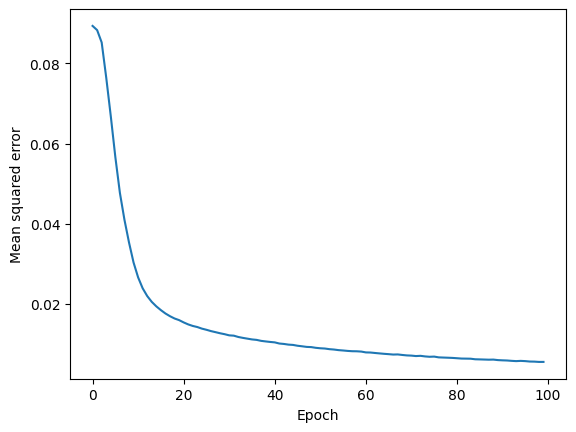

In [21]:
plt.plot(range(len(epoch_loss2)), epoch_loss2)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()

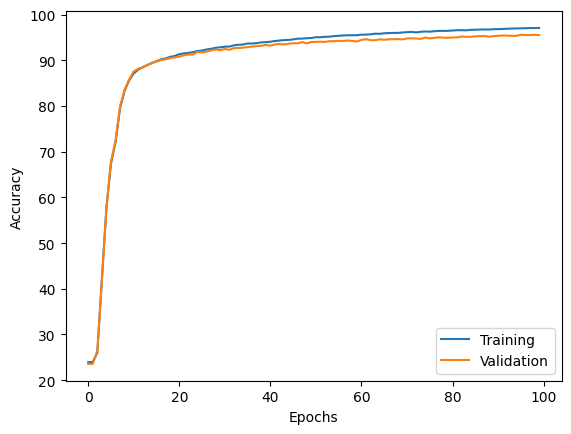

In [22]:
plt.plot(range(len(epoch_train_acc2)), epoch_train_acc2,
         label='Training')
plt.plot(range(len(epoch_valid_acc2)), epoch_valid_acc2,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

In [23]:
test_mse, test_acc = compute_mse_and_acc2(model2, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')

NameError: name 'compute_mse_and_acc2' is not defined

# Comparing to the original implementation  

In [24]:
class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()

        self.num_classes = num_classes

        # hidden
        rng = np.random.RandomState(random_seed)

        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)

        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):

        #########################
        ### Output layer weights
        #########################

        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use

        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights

        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h

        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)


        #################################
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight

        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out

        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)

        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative

        # [n_examples, n_features]
        d_z_h__d_w_h = x

        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out,
                d_loss__d_w_h, d_loss__d_b_h)



model = NeuralNetMLP(num_features=28*28,
                     num_hidden=50,
                     num_classes=10)

from sklearn.metrics import roc_auc_score
import numpy as np

def compute_mse_acc_and_macro_auc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0.0, 0, 0
    all_targets = []
    all_probas = []

    minibatch_gen = minibatch_generator(X, y, minibatch_size)

    for i, (features, targets) in enumerate(minibatch_gen):
        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)

        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas) ** 2)
        correct_pred += (predicted_labels == targets).sum()

        num_examples += targets.shape[0]
        mse += loss

        # Collect predictions for AUC calculation
        all_targets.append(onehot_targets)
        all_probas.append(probas)

    mse /= (i + 1)
    acc = correct_pred / num_examples

    # Concatenate all predictions and targets for AUC calculation
    all_targets = np.vstack(all_targets)
    all_probas = np.vstack(all_probas)

    # Compute Macro AUC
    try:
        macro_auc = roc_auc_score(all_targets, all_probas, average='macro', multi_class='ovr')
    except ValueError:
        macro_auc = np.nan  # Handle edge cases where AUC cannot be computed

    return mse, acc, macro_auc

def train(model, X_train, y_train, X_valid, y_valid, num_epochs, learning_rate=0.1, minibatch_size=100):
    """
    Trains a single-layer neural network and tracks Loss, Accuracy, and Macro AUC.

    Parameters:
    - model: The neural network model.
    - X_train, y_train: Training data and labels.
    - X_valid, y_valid: Validation data and labels.
    - num_epochs: Number of epochs for training.
    - learning_rate: Learning rate for gradient descent.
    - minibatch_size: Size of the minibatch for training.

    Returns:
    - epoch_loss: Training loss over epochs.
    - epoch_train_acc: Training accuracy over epochs.
    - epoch_valid_acc: Validation accuracy over epochs.
    - epoch_train_auc: Training macro AUC over epochs.
    - epoch_valid_auc: Validation macro AUC over epochs.
    """

    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    epoch_train_auc = []
    epoch_valid_auc = []

    for e in range(num_epochs):

        # Iterate over minibatches
        minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:

            #### Compute outputs ####
            a_h, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h   -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out   -= learning_rate * d_loss__d_b_out

        #### Epoch Logging ####
        # Compute training and validation metrics (MSE, Accuracy, Macro AUC)
        train_mse, train_acc, train_auc = compute_mse_acc_and_macro_auc(model, X_train, y_train)
        valid_mse, valid_acc, valid_auc = compute_mse_acc_and_macro_auc(model, X_valid, y_valid)

        # Convert accuracy to percentages
        train_acc, valid_acc = train_acc * 100, valid_acc * 100

        # Append metrics
        epoch_loss.append(train_mse)
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_train_auc.append(train_auc)
        epoch_valid_auc.append(valid_auc)

        #### Print Epoch Summary ####
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.4f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Train AUC: {train_auc:.4f} '
              f'| Valid Acc: {valid_acc:.2f}% '
              f'| Valid AUC: {valid_auc:.4f}')

    return epoch_loss, epoch_train_acc, epoch_valid_acc, epoch_train_auc, epoch_valid_auc

np.random.seed(123) # for the training set shuffling

epoch_loss, epoch_train_acc, epoch_valid_acc, epoch_train_auc, epoch_valid_auc = train(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs=100, learning_rate=0.1)

Epoch: 001/100 | Train MSE: 0.0632 | Train Acc: 68.50% | Train AUC: 0.9348 | Valid Acc: 68.29% | Valid AUC: 0.9330
Epoch: 002/100 | Train MSE: 0.0401 | Train Acc: 81.17% | Train AUC: 0.9605 | Valid Acc: 80.93% | Valid AUC: 0.9596
Epoch: 003/100 | Train MSE: 0.0306 | Train Acc: 85.53% | Train AUC: 0.9705 | Valid Acc: 85.45% | Valid AUC: 0.9701
Epoch: 004/100 | Train MSE: 0.0255 | Train Acc: 87.41% | Train AUC: 0.9761 | Valid Acc: 87.14% | Valid AUC: 0.9759
Epoch: 005/100 | Train MSE: 0.0226 | Train Acc: 88.70% | Train AUC: 0.9796 | Valid Acc: 88.50% | Valid AUC: 0.9795
Epoch: 006/100 | Train MSE: 0.0206 | Train Acc: 89.24% | Train AUC: 0.9814 | Valid Acc: 89.00% | Valid AUC: 0.9813
Epoch: 007/100 | Train MSE: 0.0191 | Train Acc: 89.94% | Train AUC: 0.9831 | Valid Acc: 89.62% | Valid AUC: 0.9828
Epoch: 008/100 | Train MSE: 0.0180 | Train Acc: 90.46% | Train AUC: 0.9841 | Valid Acc: 89.86% | Valid AUC: 0.9837
Epoch: 009/100 | Train MSE: 0.0172 | Train Acc: 90.67% | Train AUC: 0.9849 | Val

# comparing the models

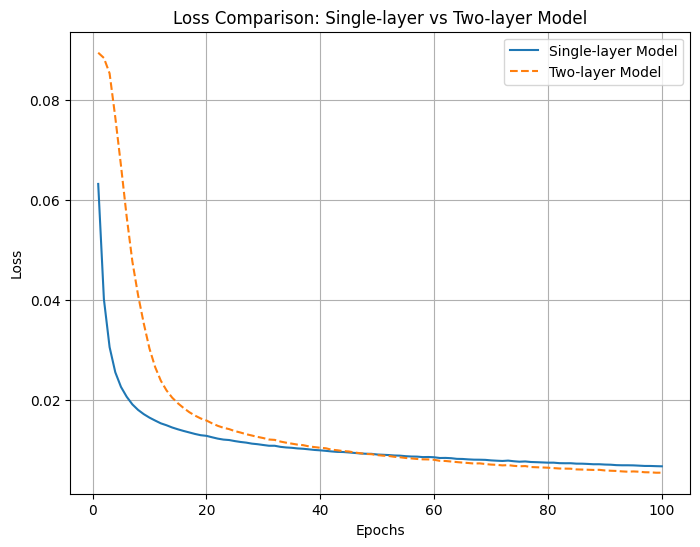

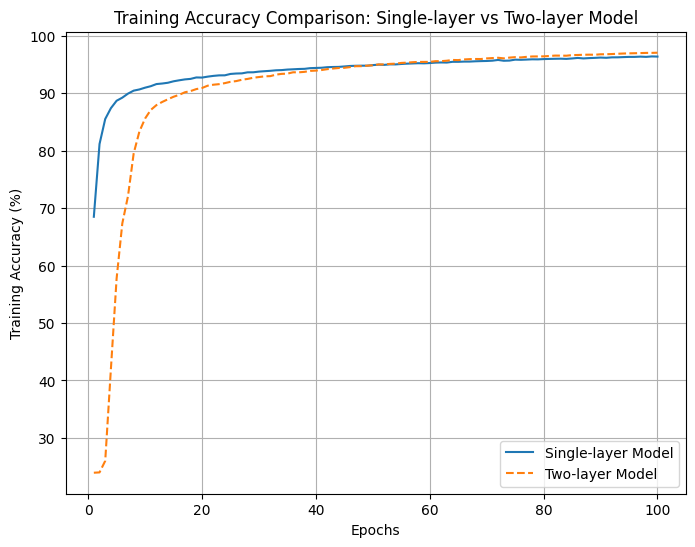

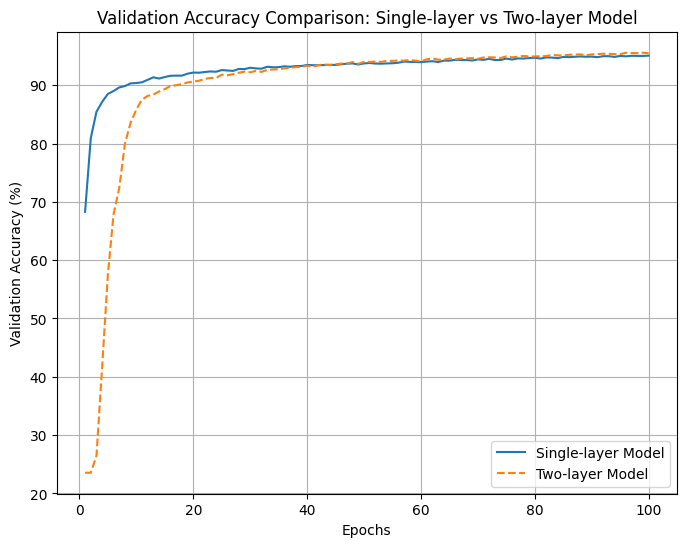

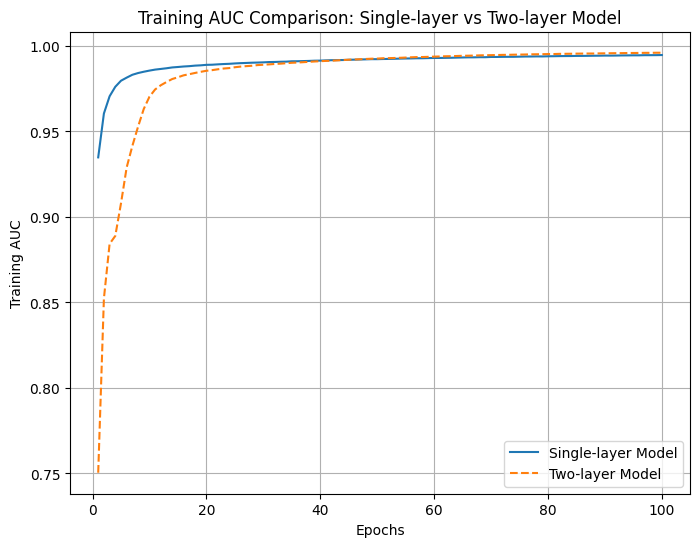

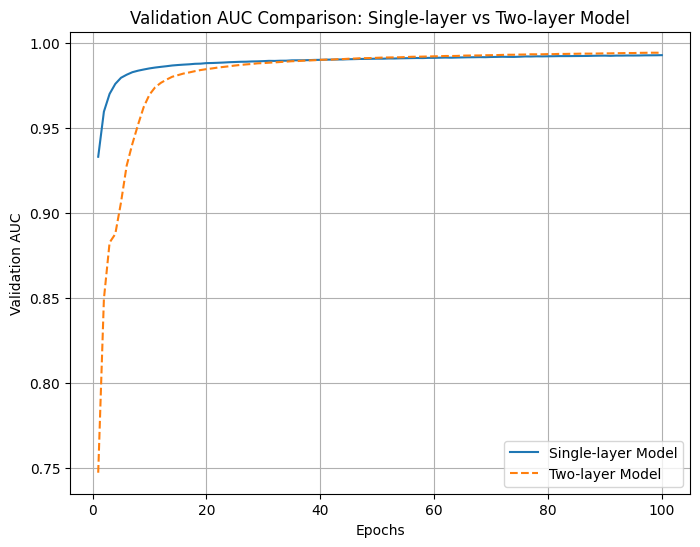

In [25]:
epochs = list(range(1, len(epoch_loss) + 1))

# Plot Loss Comparison
plt.figure(figsize=(8, 6))
plt.plot(epochs, epoch_loss, label='Single-layer Model')
plt.plot(epochs, epoch_loss2, label='Two-layer Model', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Comparison: Single-layer vs Two-layer Model')
plt.legend()

plt.grid(True)
plt.show()

# Plot Training Accuracy Comparison
plt.figure(figsize=(8, 6))
plt.plot(epochs, epoch_train_acc, label='Single-layer Model')
plt.plot(epochs, epoch_train_acc2, label='Two-layer Model', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy (%)')
plt.title('Training Accuracy Comparison: Single-layer vs Two-layer Model')
plt.legend()

plt.grid(True)
plt.show()

# Plot Validation Accuracy Comparison
plt.figure(figsize=(8, 6))
plt.plot(epochs, epoch_valid_acc, label='Single-layer Model')
plt.plot(epochs, epoch_valid_acc2, label='Two-layer Model', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy (%)')
plt.title('Validation Accuracy Comparison: Single-layer vs Two-layer Model')
plt.legend()

plt.grid(True)
plt.show()

# Plot Training AUC Comparison
plt.figure(figsize=(8, 6))
plt.plot(epochs, epoch_train_auc, label='Single-layer Model')
plt.plot(epochs, epoch_train_auc2, label='Two-layer Model', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Training AUC')
plt.title('Training AUC Comparison: Single-layer vs Two-layer Model')
plt.legend()

plt.grid(True)
plt.show()

# Plot Validation AUC Comparison
plt.figure(figsize=(8, 6))
plt.plot(epochs, epoch_valid_auc, label='Single-layer Model')
plt.plot(epochs, epoch_valid_auc2, label='Two-layer Model', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Validation AUC')
plt.title('Validation AUC Comparison: Single-layer vs Two-layer Model')
plt.legend()

plt.grid(True)
plt.show()